This notebook picks a bunch of healpix pixels, and renders a nice picture of it

In [223]:
from importlib import reload
import fitsio as fio
import numpy as np
import pandas as pd

import healpy as hp
import copy
import sys
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.decomposition as decomp


import matplotlib as mpl
import subprocess as sp
import scipy.interpolate as interpolate
import pickle as pickle
import glob
import healpy as hp
import images
import NFW

import astropy.cosmology as cosmology

import multiprocessing as mp

import synthetic.tools as tools
import synthetic.emulator.emulator as emulator
import synthetic.emulator.indexer as indexer
import synthetic.emulator.reader as reader
import synthetic.render.frame as frame
import synthetic.render.render as render


In [86]:
folder_path = "/e/ocean1/users/vargatn/LSST/SYNTHETIC/"

In [87]:
in_path = "/e/ocean1/users/vargatn/LSST/DC2_1.1.4/"

In [88]:
fnames = glob.glob(in_path + "*pixel*h5")
pixels = np.array([int(tmp.split("-")[-1].split(".")[0]) for tmp in fnames])

In [89]:
pixel_id = 0

In [90]:
alltable = pd.read_hdf(fnames[pixel_id], key='data')
ra_cen = np.mean(alltable["ra"])
dec_cen = np.mean(alltable["dec"])

In [91]:
pad = 0.17 # degree
mag_max = 25

ii = (np.abs(alltable["ra"] - ra_cen) < pad) & (np.abs(alltable["dec"] - dec_cen) < pad) & (alltable['mag_i'] < mag_max)
table = alltable[ii]
ra = (table["ra"] - ra_cen) * 60. 
dec = (table["dec"] - dec_cen) * 60.

# This is the pre injection canvas

In [92]:
pixel_scale = 0.264
mock_catalog = pd.DataFrame()
mock_catalog["RA"] = table["ra"]
mock_catalog["DEC"] = table["dec"]
mock_catalog["X"] = (table["ra"] - ra_cen) * 60 * 60 / pixel_scale + 2499.5
mock_catalog["Y"] = (table["dec"] - dec_cen) * 60 * 60 / pixel_scale + 2499.5

mock_catalog["MAG_I"] = table["mag_i"]
mock_catalog["TSIZE"] = table["size_true"]
mock_catalog["FRACDEV"] = 0
mock_catalog["FLUX_I"] = tools.toflux(table["mag_i"])
mock_catalog["G1"] = table["ellipticity_1_true"]
mock_catalog["G2"] = table["ellipticity_2_true"]

In [188]:
def make_mock(table, sky_center,  pixel_scale=0.264, image_offset=(2499.5, 2499.5)):
    pixel_scale = 0.264
    mock_catalog = pd.DataFrame()
    mock_catalog["RA"] = table["ra"]
    mock_catalog["DEC"] = table["dec"]
    mock_catalog["X"] = (table["ra"] - sky_center[0]) * 60 * 60 / pixel_scale + image_offset[0]
    mock_catalog["Y"] = (table["dec"] - sky_center[1]) * 60 * 60 / pixel_scale + image_offset[1]

    mock_catalog["MAG_G"] = table["mag_g"]
    mock_catalog["FLUX_G"] = tools.toflux(table["mag_g"])
    mock_catalog["MAG_R"] = table["mag_i"]
    mock_catalog["FLUX_R"] = tools.toflux(table["mag_r"])
    mock_catalog["MAG_I"] = table["mag_i"]
    mock_catalog["FLUX_I"] = tools.toflux(table["mag_i"])
    mock_catalog["MAG_Z"] = table["mag_z"]
    mock_catalog["FLUX_Z"] = tools.toflux(table["mag_z"])

    mock_catalog["TSIZE"] = table["size_true"]
    mock_catalog["FRACDEV"] = 0
    mock_catalog["G1"] = table["ellipticity_1_true"]
    mock_catalog["G2"] = table["ellipticity_2_true"]    
    return mock_catalog

def radec2xy(ra, dec, sky_center,  pixel_scale=0.264, image_offset=(2499.5, 2499.5)):
    x = (ra - sky_center[0]) * 60 * 60 / pixel_scale + image_offset[0]
    y = (dec - sky_center[1]) * 60 * 60 / pixel_scale + image_offset[1]
    return x.values, y.values

In [119]:
mock_catalog = make_mock(table, sky_center=(ra_cen, dec_cen))

In [78]:
len(table) / (0.1 * 60)**2.

378.6666666666667

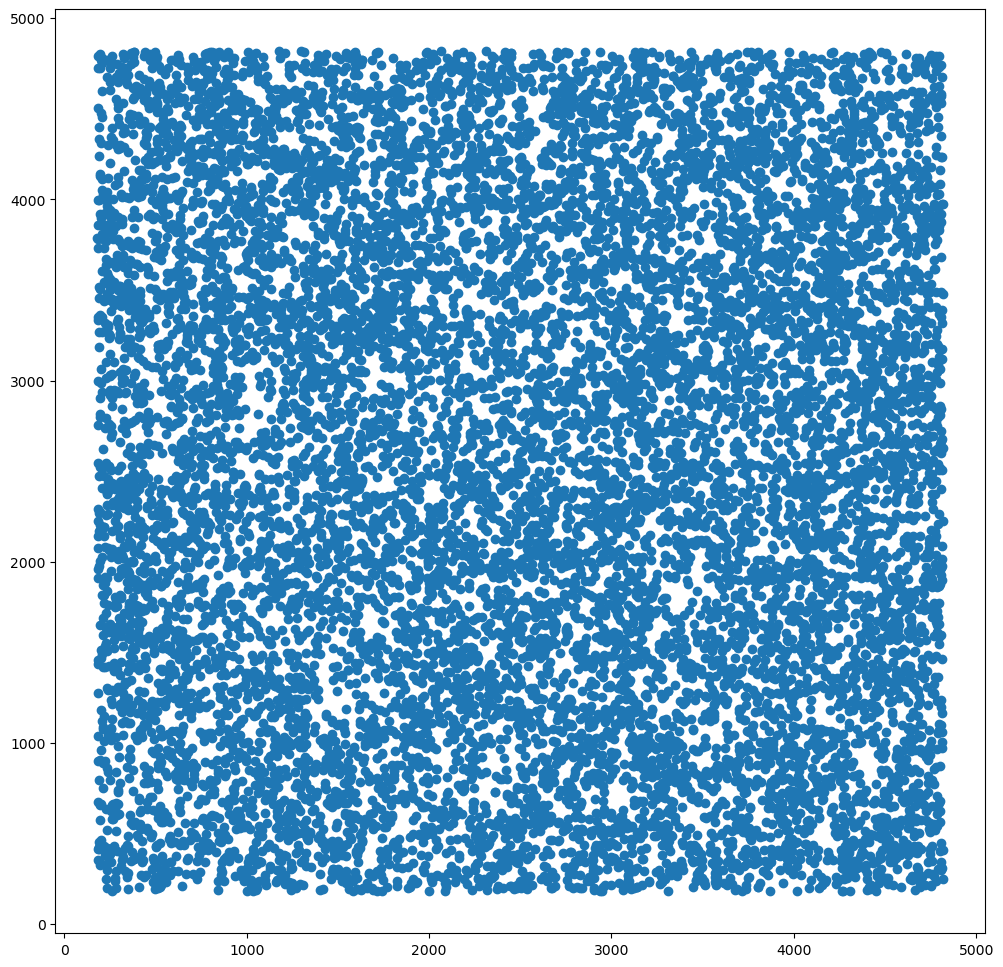

In [79]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)


ax.scatter(mock_catalog["X"], mock_catalog["Y"])

In [121]:
stds = np.array([2.509813, 5.192254, 8.36335, 15.220351]) / 1.3
for i, band in enumerate(("g", "r", "i")):
    name = folder_path + 'test_canvas_grid_' + band
    print(name)
    fr = frame.Frame(mock_catalog.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=stds[i], canvas_size=5000)
    fr.render() 

/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_g
starting xshear calculations in 100 processes
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_r
starting xshear calculations in 100 processes
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_i
starting xshear calculations in 100 processes


In [122]:
ims_all = []
for i, band in enumerate(("g", "r", "i")):
    name = folder_path + 'test_canvas_grid_' + band + ".fits"
    tmp = fio.read(name)
    print(name)
    ims_all.append(tmp)

/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_g.fits
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_r.fits
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_i.fits


0.9392495155334473


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


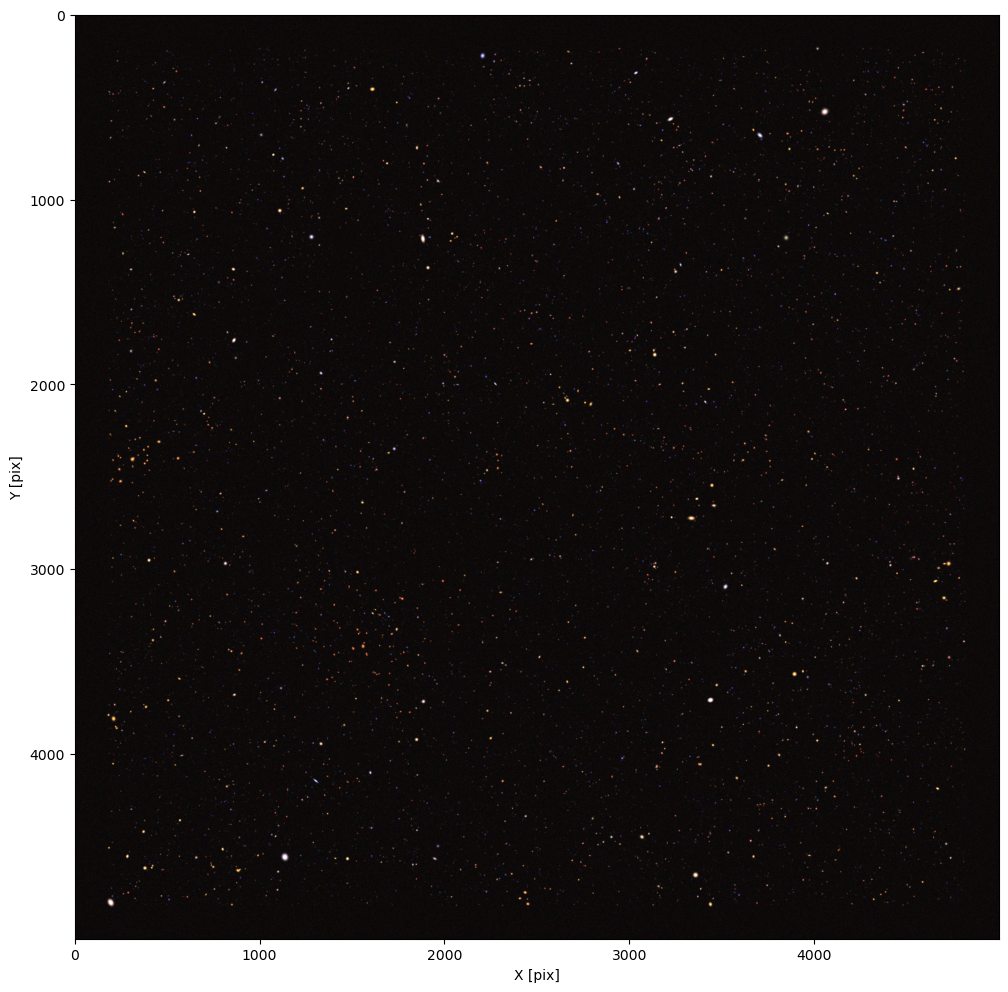

In [211]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_all[2],# + ims_icl[2] + noises[2] + pad,
                                ims_all[1],# + ims_icl[1] + noises[1] + pad,
                                ims_all[0],# + ims_icl[0] + noises[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im * 2, origin='upper')

# ax.set_title("cluster + field rendered together")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
fig.savefig("dc2_hp.png", bbox_inches='tight')

Let's look at the most masive 10 halos in more detail

In [212]:
ihmaxes = np.argsort(table["halo_mass"])[::-1]

In [213]:
masses = table["halo_mass"][table["is_central"]].iloc[np.argsort(table["halo_mass"][table["is_central"]])[-10:]]
ras = table["ra"][table["is_central"]].iloc[np.argsort(table["halo_mass"][table["is_central"]])[-10:]]
decs = table["dec"][table["is_central"]].iloc[np.argsort(table["halo_mass"][table["is_central"]])[-10:]]
xh, yh = radec2xy(ras, decs, sky_center=(ra_cen, dec_cen))

In [214]:
marker_sizes = (np.log10(masses).values - 12.6) ** 4 * 30

array([3416.46127751, 3807.58707247, 2403.74171904, 1606.1850579 ,
        470.39581575, 2831.61123797, 4748.17560675, 1435.60652068,
       1519.76691823, 4176.4363955 ])

0.9392495155334473


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


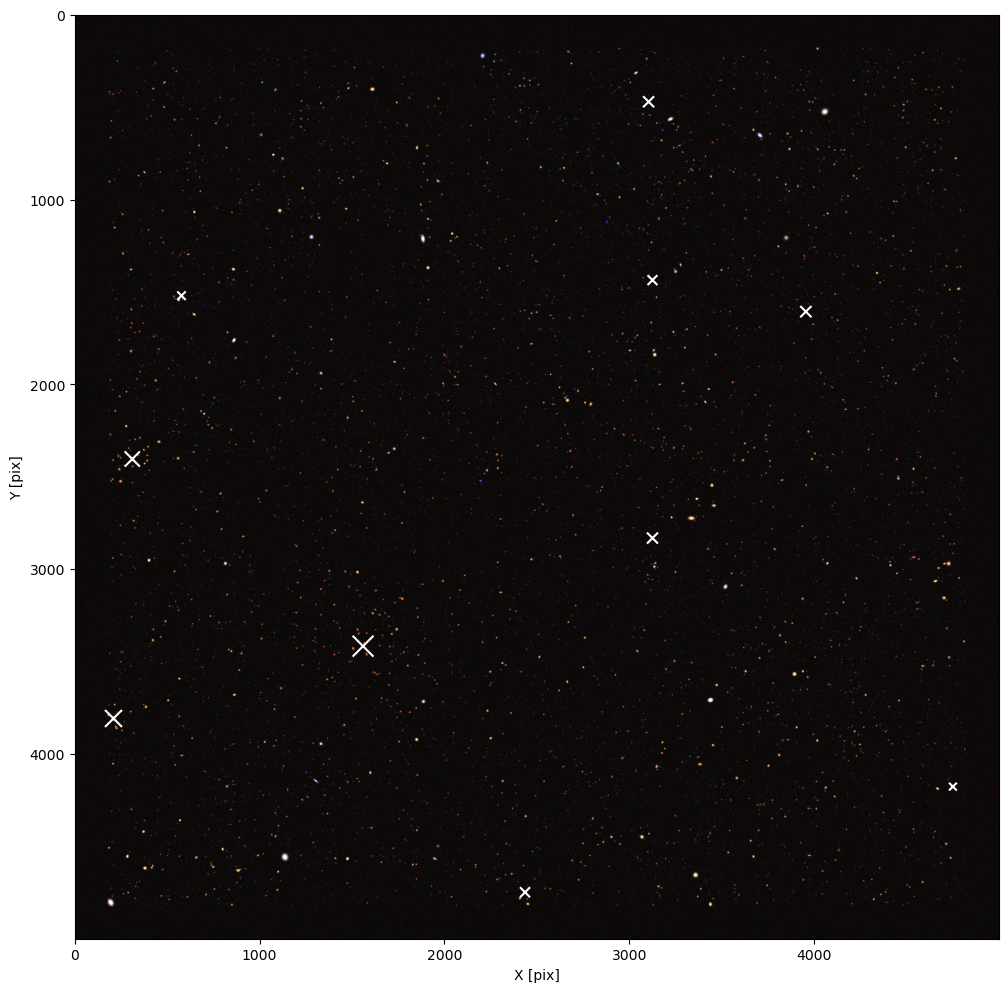

In [220]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_all[2],# + ims_icl[2] + noises[2] + pad,
                                ims_all[1],# + ims_icl[1] + noises[1] + pad,
                                ims_all[0],# + ims_icl[0] + noises[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im * 2, origin='upper')
ax.scatter(xh[::-1], yh[::-1], s=marker_sizes[::-1], color="white", marker="x")

# ax.set_title("cluster + field rendered together")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
fig.savefig("dc2_hp_halos_in_FOV.png", bbox_inches='tight')

In [144]:
table['halo_mass'].iloc[ihmaxes[:10]]

661956    1.808167e+14
661977    1.808167e+14
661963    1.808167e+14
661964    1.808167e+14
661965    1.808167e+14
661966    1.808167e+14
661967    1.808167e+14
661968    1.808167e+14
661969    1.808167e+14
661970    1.808167e+14
Name: halo_mass, dtype: float64

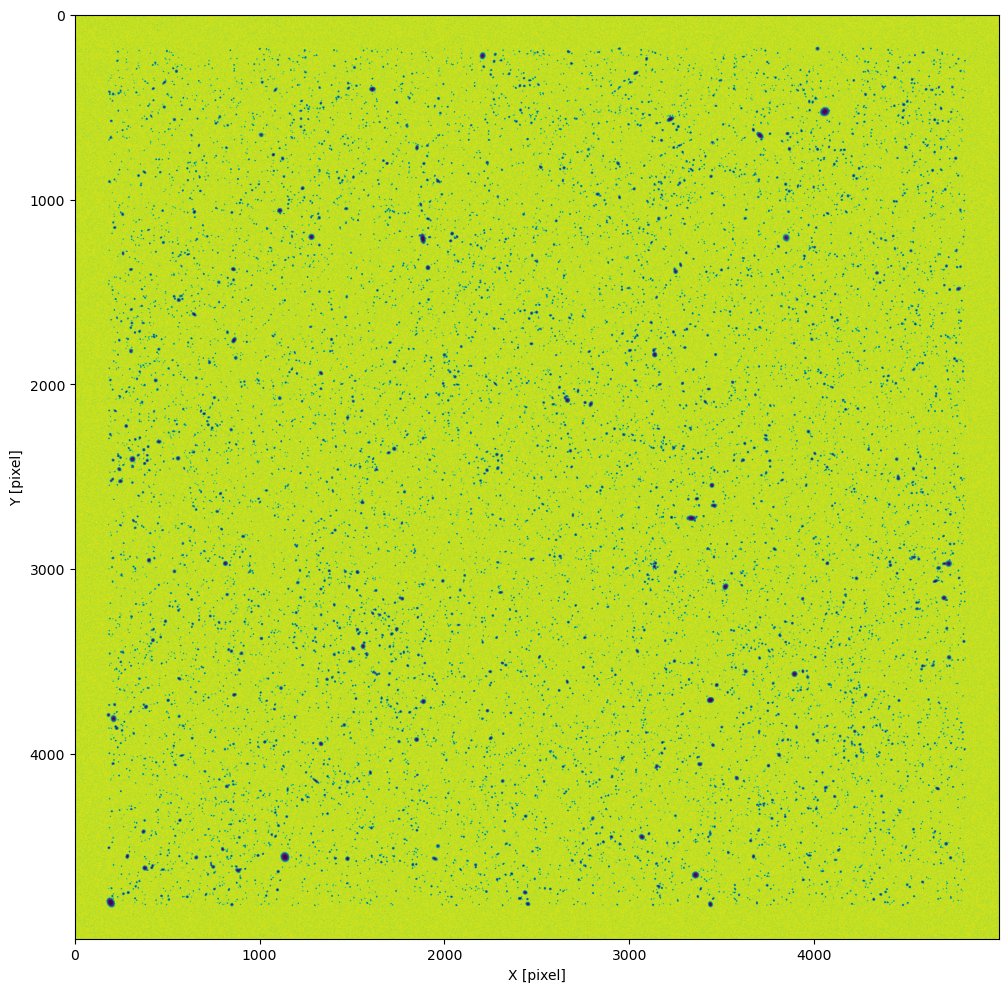

In [84]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
arr = fr.canvas.array
ax.imshow(np.arcsinh(arr) / arr)
ax.set_xlabel("X [pixel]")
ax.set_ylabel("Y [pixel]")

fig.savefig("DC2_noinject_render.png")

# Making some extra strong shears

In [224]:
cosmo = cosmology.FlatLambdaCDM(Om0=0.3, H0=70)

In [249]:
mock_catalog = make_mock(table, sky_center=(ra_cen, dec_cen))

dists = np.sqrt((mock_catalog["RA"] - ra_cen)**2 + (mock_catalog["DEC"] - dec_cen)**2)
shears = np.sqrt(1 / (dists * 30)  / 3) # just for illustration purposes
shears[shears > 0.8] = 0.8

phis =  np.arctan2(mock_catalog["DEC"], mock_catalog["RA"])
es1 = (-1. * shears * np.cos(2 * phis))
es2 = (-1. * shears * np.sin(2 * phis))

mock_catalog["G1"] = es1
mock_catalog["G2"] = es2

# e1 = mock_catalog["G1"]
# e2 = mock_catalog["G2"]

# vals1 = e1 + es1 - e1 * es1 - e2 * es2
# vals2 = e2 + es2 - es1 * e2 + es2 * e1

# tmp = np.sqrt(vals1**2. + vals2**2.)
# ii = tmp > 0.95
# divs = 1. / (0.1 + tmp[ii])  
# vals1[ii] *= divs
# vals2[ii] *= divs

# mock_catalog["G1"] = vals1
# mock_catalog["G2"] = vals2

In [ ]:
stds = np.array([2.509813, 5.192254, 8.36335, 15.220351]) / 1.3
for i, band in enumerate(("g", "r", "i")):
    name = folder_path + 'test_canvas_grid_isothermal_' + band
    print(name)
    fr = frame.Frame(mock_catalog.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=stds[i], canvas_size=5000)
    fr.render() 

/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_isothermal_g
starting xshear calculations in 100 processes
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_isothermal_r
starting xshear calculations in 100 processes


In [ ]:
ims_all = []
for i, band in enumerate(("g", "r", "i")):
    name = folder_path + 'test_canvas_grid_isothermal_' + band + ".fits"
    tmp = fio.read(name)
    print(name)
    ims_all.append(tmp)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_all[2],# + ims_icl[2] + noises[2] + pad,
                                ims_all[1],# + ims_icl[1] + noises[1] + pad,
                                ims_all[0],# + ims_icl[0] + noises[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im[2000:3000, 2000:3000] * 2, origin='upper')

# ax.set_title("cluster + field rendered together")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
fig.savefig("dc2_hp_isothermal.png", bbox_inches='tight')